In [1]:
# 시간 측정 
!pip install ipython-autotime
%load_ext autotime

time: 0 ns (started: 2021-12-19 18:00:16 +09:00)


In [2]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
from plotnine import *
import re
import torch
import tqdm
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split 
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
import os, random
import tensorflow as tf

time: 15 s (started: 2021-12-19 18:00:16 +09:00)


### 스팀 리뷰 데이터

In [3]:
steam_data = pd.read_csv('steam.txt',sep='\t', names=['label', 'text'])

time: 313 ms (started: 2021-12-19 18:00:53 +09:00)


In [4]:
# 부정은 0, 긍정은 1로 표시
steam_data

,label,text
0,0,노래가 너무 적음
1,0,"돌겠네 진짜. 황숙아, 어크 공장 그만 돌려라. 죽는다."
2,1,막노동 체험판 막노동 하는사람인데 장비를 내가 사야돼 뭐지
3,1,차악!차악!!차악!!! 정말 이래서 왕국을 되찾을 수 있는거야??
4,1,시간 때우기에 좋음.. 도전과제는 50시간이면 다 깰 수 있어요
...,...,...
99995,0,한글화해주면 10개산다
99996,0,개쌉노잼 ㅋㅋ
99997,0,노잼이네요... 30분하고 지웠어요...
99998,1,야생을 사랑하는 사람들을 위한 짧지만 여운이 남는 이야기. 영어는 그리 어렵지 않습니다.


time: 16 ms (started: 2021-12-19 18:00:58 +09:00)


In [5]:
#한글이 아니면 빈 문자열로 바꾸기
steam_data['text'] = steam_data['text'].str.replace('[^가-힣\s]','',regex=True)

time: 234 ms (started: 2021-12-19 18:01:00 +09:00)


In [6]:
steam_data

,label,text
0,0,노래가 너무 적음
1,0,돌겠네 진짜 황숙아 어크 공장 그만 돌려라 죽는다
2,1,막노동 체험판 막노동 하는사람인데 장비를 내가 사야돼 뭐지
3,1,차악차악차악 정말 이래서 왕국을 되찾을 수 있는거야
4,1,시간 때우기에 좋음 도전과제는 시간이면 다 깰 수 있어요
...,...,...
99995,0,한글화해주면 개산다
99996,0,개쌉노잼
99997,0,노잼이네요 분하고 지웠어요
99998,1,야생을 사랑하는 사람들을 위한 짧지만 여운이 남는 이야기 영어는 그리 어렵지 않습니다


time: 0 ns (started: 2021-12-19 18:01:01 +09:00)


C:\Users\nsw20\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
C:\Users\nsw20\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.


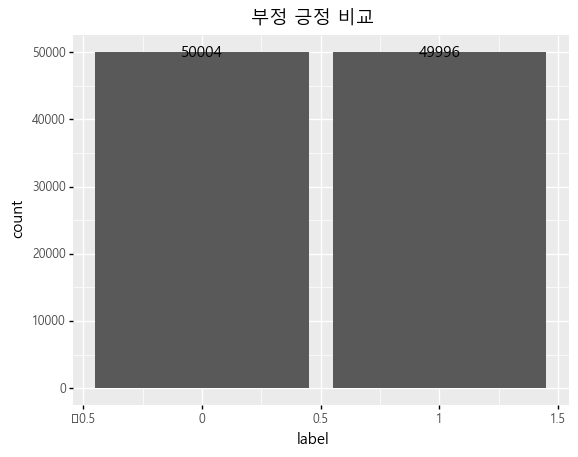

<ggplot: (150357082673)>

time: 687 ms (started: 2021-12-19 18:01:03 +09:00)


In [7]:
(ggplot(steam_data)
 + aes('label')
 + geom_bar()
 + geom_text(aes(label='..count..'), stat='count')
 + ggtitle('부정 긍정 비교')
 + theme(text=element_text(family='Malgun Gothic'))
)

In [8]:
# GPU 사용 
device = torch.device('cpu')

time: 0 ns (started: 2021-12-19 18:01:11 +09:00)


In [12]:
# 학습 데이터, 테스트 데이터 분리 size = 8:2
train_data, test_data = train_test_split(steam_data, test_size=0.2, random_state=0)

time: 31 ms (started: 2021-12-19 18:02:59 +09:00)


In [13]:
print("train set: {}개".format(len(train_data)))
print("test set: {}개".format(len(test_data)))

train set: 80000개
test set: 20000개
time: 0 ns (started: 2021-12-19 18:03:00 +09:00)


In [14]:
train_data.head()

,label,text
10382,1,너무너무너무너무 귀엽고 그림체가 좋아서 샀다 애기들만 좋아할거란 편견은 버렷 계절의...
73171,1,년 월 일 블렉웨스트는 오렌지병 이었던 강력한 겜으로 쓰러졌다 여러분 제발 이겜 하...
30938,0,뭐야시발 옛날에 산 무기들 가치 다 없어진거임
99310,1,인생게임 엔딩본게임
58959,1,아니 가 별로라구요 그럼 사서 하세요 이것마저 별로라구요 그럼 넌분기에 ...


time: 16 ms (started: 2021-12-19 18:03:02 +09:00)


In [15]:
test_data.head()

,label,text
3582,0,게임을 하면 즐겨야하는데 정신병자 쳐다보고있으니 나도 따라가는듯 하다 정신병을 잘 ...
60498,0,게임이 그냥 이건 아니다
53227,0,더럽개 재미 없네
21333,1,저렴한 가격으로 도전과제 개를 지금 당장 주문하세요
3885,0,키보드 게임이 아니다 키보드는 인용밖에 안되고 그마저도 키변경이 안되서 사실상 플레...


time: 0 ns (started: 2021-12-19 18:03:02 +09:00)


In [18]:
# 학습 데이터 중복값 제거
train_data['text'].nunique(), train_data['label'].nunique()

(79455, 2)

time: 78 ms (started: 2021-12-19 18:03:39 +09:00)


In [19]:
train_data.drop_duplicates(subset=['text'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거

time: 63 ms (started: 2021-12-19 18:03:39 +09:00)


C:\Users\nsw20\AppData\Local\Temp/ipykernel_11904/2746220271.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [20]:
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 79455
time: 0 ns (started: 2021-12-19 18:03:42 +09:00)


In [21]:
# 테스트 데이터 중복값 제거
test_data['text'].nunique(), train_data['label'].nunique()

(19963, 2)

time: 31 ms (started: 2021-12-19 18:03:54 +09:00)


In [22]:
test_data.drop_duplicates(subset=['text'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거

time: 16 ms (started: 2021-12-19 18:03:59 +09:00)


C:\Users\nsw20\AppData\Local\Temp/ipykernel_11904/1897176215.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [23]:
print('총 테스트 샘플의 수 :',len(test_data))

총 테스트 샘플의 수 : 19963
time: 0 ns (started: 2021-12-19 18:04:01 +09:00)


<AxesSubplot:>

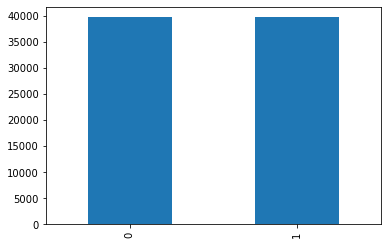

time: 172 ms (started: 2021-12-19 18:04:14 +09:00)


In [25]:
# 학습 데이터 부정 긍정 개수 비교
train_data['label'].value_counts().plot(kind = 'bar')

In [26]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  39742
1      1  39713
time: 0 ns (started: 2021-12-19 18:04:18 +09:00)


In [27]:
print(train_data.isnull().values.any())

False
time: 16 ms (started: 2021-12-19 18:04:22 +09:00)


In [28]:
train_data['text'] = train_data['text'].str.replace("[^가-힣 ]","")
# 한글과 공백을 제외하고 모두 제거
train_data[:5]

C:\Users\nsw20\AppData\Local\Temp/ipykernel_11904/1179348747.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\nsw20\AppData\Local\Temp/ipykernel_11904/1179348747.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,label,text
10382,1,너무너무너무너무 귀엽고 그림체가 좋아서 샀다 애기들만 좋아할거란 편견은 버렷 계절의...
73171,1,년 월 일 블렉웨스트는 오렌지병 이었던 강력한 겜으로 쓰러졌다 여러분 제발 이겜 하...
30938,0,뭐야시발 옛날에 산 무기들 가치 다 없어진거임
99310,1,인생게임 엔딩본게임
58959,1,아니 가 별로라구요 그럼 사서 하세요 이것마저 별로라구요 그럼 넌분기에 ...


time: 140 ms (started: 2021-12-19 18:04:25 +09:00)


In [29]:
test_data.drop_duplicates(subset = ['text'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['text'] = test_data['text'].str.replace("[^가-힣 ]","") # 정규 표현식 수행
test_data['text'] = test_data['text'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test_data['text'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 19963
time: 109 ms (started: 2021-12-19 18:04:39 +09:00)


C:\Users\nsw20\AppData\Local\Temp/ipykernel_11904/589794599.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\nsw20\AppData\Local\Temp/ipykernel_11904/589794599.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\nsw20\AppData\Local\Temp/ipykernel_11904/589794599.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\nsw20\AppData\Local\Temp/ipykernel_11904/589794599.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\nsw20\AppData\Local\

### 데이터 토크나이징

In [30]:
okt = Okt()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

time: 1.14 s (started: 2021-12-19 18:05:07 +09:00)


In [31]:
X_train = []
for sentence in train_data['text']:
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

time: 3min 46s (started: 2021-12-19 18:05:09 +09:00)


In [32]:
print(X_train[:3])

[['너무', '너무', '너무', '너무', '귀엽다', '그림', '체', '좋다', '사다', '애기', '만', '좋아하다', '편견', '버렷', '계절', '무한', '루프', '사실', '플레이', '시간', '정말', '짧다', '해보다'], ['년', '월', '일', '블렉', '웨스트', '오렌지', '병', '이다', '강력하다', '겜', '쓰러지다', '여러분', '제발', '겜', '얼굴', '태보', '싶다', '게임', '이다'], ['뭐', '야', '시발', '옛날', '산', '무기', '가치', '다', '없어지다', '임']]
time: 16 ms (started: 2021-12-19 18:08:55 +09:00)


In [33]:
X_test = []
for sentence in test_data['text']:
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

time: 57.4 s (started: 2021-12-19 18:08:55 +09:00)


In [34]:
print(X_test[:3])

[['게임', '을', '즐기다', '정신병', '쳐다보다', '나다', '따라가다', '정신병', '을', '자다', '표현', '그', '이상', '장점', '없다', '비', '추천'], ['게임', '그냥', '이건', '아니다'], ['더럽다', '개', '재미', '없다']]
time: 0 ns (started: 2021-12-19 18:09:53 +09:00)


In [35]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

time: 1.66 s (started: 2021-12-19 18:09:53 +09:00)


In [36]:
print(tokenizer.word_index)

{'게임': 1, '을': 2, '있다': 3, '없다': 4, '되다': 5, '이다': 6, '좋다': 7, '같다': 8, '보다': 9, '로': 10, '재밌다': 11, '안': 12, '겜': 13, '만': 14, '너무': 15, '다': 16, '않다': 17, '아니다': 18, '플레이': 19, '시간': 20, '못': 21, '적': 22, '것': 23, '에서': 24, '안되다': 25, '때': 26, '사다': 27, '나': 28, '추천': 29, '사람': 30, '재미': 31, '고': 32, '거': 33, '해보다': 34, '인': 35, '재미있다': 36, '개': 37, '만들다': 38, '나오다': 39, '생각': 40, '스토리': 41, '그냥': 42, '더': 43, '내': 44, '모르다': 45, '하고': 46, '게': 47, '수': 48, '왜': 49, '진짜': 50, '많다': 51, '갓': 52, '그': 53, '정말': 54, '아': 55, '버그': 56, '가다': 57, '어렵다': 58, '그래픽': 59, '돈': 60, '정도': 61, '요': 62, '그렇다': 63, '하': 64, '함': 65, '들다': 66, '뭐': 67, '자다': 68, '분': 69, '면': 70, '친구': 71, '중': 72, '인데': 73, '해주다': 74, '처음': 75, '싶다': 76, '알다': 77, '환불': 78, '느낌': 79, '주다': 80, '까지': 81, '즐기다': 82, '하나': 83, '일': 84, '말': 85, '좋아하다': 86, '임': 87, '하지만': 88, '멀티': 89, '감': 90, '버리다': 91, '받다': 92, '오다': 93, '말다': 94, '난이도': 95, '저': 96, '걸': 97, '많이': 98, '실행': 99, '구매': 100, '엔딩': 101, '지': 102, '그

In [37]:
# Vocabulary 크기 설정

threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30981
등장 빈도가 2번 이하인 희귀 단어의 수: 17751
단어 집합에서 희귀 단어의 비율: 57.29640747554953
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.9997527866844267
time: 32 ms (started: 2021-12-19 18:09:54 +09:00)


In [38]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 13231
time: 0 ns (started: 2021-12-19 18:09:55 +09:00)


In [39]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

time: 2.66 s (started: 2021-12-19 18:09:55 +09:00)


In [40]:
print(X_train[:3])

[[15, 15, 15, 15, 263, 567, 1093, 7, 27, 5564, 14, 86, 5840, 5358, 6496, 580, 4969, 423, 19, 20, 54, 167, 34], [184, 901, 84, 11143, 9766, 5841, 1391, 6, 2064, 13, 3436, 699, 302, 13, 1574, 6135, 76, 1, 6], [67, 181, 141, 372, 451, 367, 631, 16, 772, 87]]
time: 0 ns (started: 2021-12-19 18:09:57 +09:00)


In [41]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

time: 0 ns (started: 2021-12-19 18:09:57 +09:00)


In [42]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

time: 31 ms (started: 2021-12-19 18:09:57 +09:00)


In [43]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

79138
79138
time: 47 ms (started: 2021-12-19 18:09:57 +09:00)


C:\Users\nsw20\Anaconda3\lib\site-packages\numpy\lib\function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


리뷰의 최대 길이 : 63
리뷰의 평균 길이 : 13.424713791099093


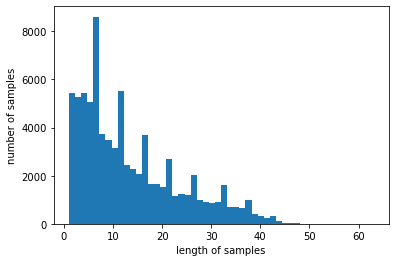

time: 454 ms (started: 2021-12-19 18:09:57 +09:00)


In [44]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [45]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

time: 16 ms (started: 2021-12-19 18:09:58 +09:00)


In [46]:
max_len = 35
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 35 이하인 샘플의 비율: 95.92989461447092
time: 31 ms (started: 2021-12-19 18:09:58 +09:00)


In [47]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

time: 343 ms (started: 2021-12-19 18:09:58 +09:00)


### 실제 학습 진행

### LSTM

In [48]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

time: 0 ns (started: 2021-12-19 18:10:48 +09:00)


In [49]:
embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         1323100   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,440,477
Trainable params: 1,440,477
Non-trainable params: 0
_________________________________________________________________
time: 422 ms (started: 2021-12-19 18:10:49 +09:00)


In [50]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('C:\\Users\\nsw20\\best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

time: 0 ns (started: 2021-12-19 18:11:00 +09:00)


In [51]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train,
                    y_train,
                    epochs= 20,
                    batch_size=64, # 512, 100, 60 
                    validation_data=(X_test, y_test),
                    callbacks = [es, mc])

Epoch 1/20
1236/1237 [============================>.] - ETA: 0s - loss: 0.4983 - acc: 0.7611
Epoch 00001: val_acc improved from -inf to 0.77749, saving model to C:\Users\nsw20\best_model.h5
1237/1237 [==============================] - 63s 50ms/step - loss: 0.4984 - acc: 0.7611 - val_loss: 0.4694 - val_acc: 0.7775
Epoch 2/20
1236/1237 [============================>.] - ETA: 0s - loss: 0.4377 - acc: 0.7996
Epoch 00002: val_acc improved from 0.77749 to 0.78756, saving model to C:\Users\nsw20\best_model.h5
1237/1237 [==============================] - 61s 49ms/step - loss: 0.4377 - acc: 0.7996 - val_loss: 0.4509 - val_acc: 0.7876
Epoch 3/20
1236/1237 [============================>.] - ETA: 0s - loss: 0.4121 - acc: 0.8145
Epoch 00003: val_acc improved from 0.78756 to 0.79016, saving model to C:\Users\nsw20\best_model.h5
1237/1237 [==============================] - 62s 50ms/step - loss: 0.4121 - acc: 0.8145 - val_loss: 0.4560 - val_acc: 0.7902
Epoch 4/20
1236/1237 [===========================

In [52]:
loaded_model = load_model('C:\\Users\\nsw20\\best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

624/624 [==============================] - 6s 10ms/step - loss: 0.4406 - acc: 0.7942

 테스트 정확도: 0.7942
time: 6.59 s (started: 2021-12-19 18:22:31 +09:00)


In [53]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])
time: 0 ns (started: 2021-12-19 18:22:39 +09:00)


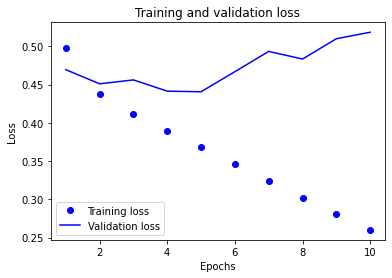

time: 437 ms (started: 2021-12-19 18:22:40 +09:00)


In [54]:
acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

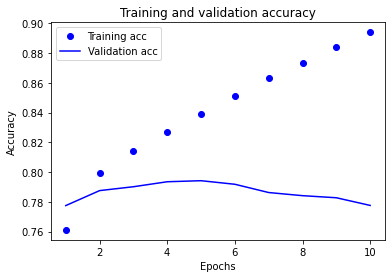

time: 203 ms (started: 2021-12-19 18:22:46 +09:00)


In [55]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### LSTM + 기존 word vector 사용

In [57]:
from gensim.models import Word2Vec
import os

# 한국어 Word2Vec 사용
word2vec_path = 'C:\\Users\\nsw20\\ko.bin'
word2vec = Word2Vec.load(word2vec_path)

print(word2vec)

Word2Vec(vocab=30185, size=200, alpha=0.025)
time: 609 ms (started: 2021-12-19 18:23:32 +09:00)


In [64]:
# Index to word
word_to_index = {word:index for index, word in enumerate(tokenizer.word_index)}

index_to_word = {index:word for word, index in word_to_index.items()}

time: 0 ns (started: 2021-12-19 19:33:19 +09:00)


In [65]:
word_vector_dim = 200  
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

time: 16 ms (started: 2021-12-19 19:33:23 +09:00)


In [66]:
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

time: 125 ms (started: 2021-12-19 19:33:24 +09:00)


C:\Users\nsw20\AppData\Local\Temp/ipykernel_11904/2907652819.py:5: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
C:\Users\nsw20\AppData\Local\Temp/ipykernel_11904/2907652819.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [67]:
from tensorflow.keras.initializers import Constant

model_transfer = keras.Sequential()
model_transfer.add(keras.layers.Embedding(vocab_size, 
                   word_vector_dim, 
                   embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                   input_length=max_len, 
                   trainable=True))
model_transfer.add(keras.layers.LSTM(128))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 64로 하였습니다. (변경가능)
model_transfer.add(keras.layers.Dense(8, activation='relu')) # 안해도 됨
model_transfer.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_transfer.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 35, 200)           2646200   
                                                                 
 lstm_1 (LSTM)               (None, 128)               168448    
                                                                 
 dense_1 (Dense)             (None, 8)                 1032      
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2,815,689
Trainable params: 2,815,689
Non-trainable params: 0
_________________________________________________________________
time: 344 ms (started: 2021-12-19 19:33:26 +09:00)


In [68]:
es_transfer = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc_transfer = ModelCheckpoint('C:\\Users\\nsw20\\best_model_transfer.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

time: 0 ns (started: 2021-12-19 19:33:28 +09:00)


In [69]:
model_transfer.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model_transfer.fit(X_train,
                    y_train,
                    epochs= 20,
                    batch_size=64, # 512, 100, 60 
                    validation_data=(X_test, y_test),
                    callbacks = [es_transfer, mc_transfer])

Epoch 1/20
1237/1237 [==============================] - ETA: 0s - loss: 0.5274 - acc: 0.7297
Epoch 00001: val_acc improved from -inf to 0.77393, saving model to C:\Users\nsw20\best_model_transfer.h5
1237/1237 [==============================] - 119s 94ms/step - loss: 0.5274 - acc: 0.7297 - val_loss: 0.4701 - val_acc: 0.7739
Epoch 2/20
1237/1237 [==============================] - ETA: 0s - loss: 0.4288 - acc: 0.8024
Epoch 00002: val_acc improved from 0.77393 to 0.78099, saving model to C:\Users\nsw20\best_model_transfer.h5
1237/1237 [==============================] - 109s 88ms/step - loss: 0.4288 - acc: 0.8024 - val_loss: 0.4604 - val_acc: 0.7810
Epoch 3/20
1237/1237 [==============================] - ETA: 0s - loss: 0.3787 - acc: 0.8321
Epoch 00003: val_acc improved from 0.78099 to 0.78335, saving model to C:\Users\nsw20\best_model_transfer.h5
1237/1237 [==============================] - 111s 90ms/step - loss: 0.3787 - acc: 0.8321 - val_loss: 0.4632 - val_acc: 0.7833
Epoch 4/20
1237/123

In [70]:
loaded_model = load_model('C:\\Users\\nsw20\\best_model_transfer.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

624/624 [==============================] - 7s 11ms/step - loss: 0.4632 - acc: 0.7833

 테스트 정확도: 0.7833
time: 10.4 s (started: 2021-12-19 19:47:37 +09:00)


### LSTM + CNN

In [71]:
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

time: 0 ns (started: 2021-12-19 19:47:49 +09:00)


In [72]:
embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Dropout(0.25))
model.add(Conv1D(64, 5, padding="valid", activation="relu", strides=1))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation="sigmoid"))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 100)         1323100   
                                                                 
 dropout (Dropout)           (None, None, 100)         0         
                                                                 
 conv1d (Conv1D)             (None, None, 64)          32064     
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 64)         0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 128)               98816     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                      

In [73]:
es_cnn_lstm = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)
mc_cnn_lstm = ModelCheckpoint('C:\\Users\\nsw20\\best_model_cnn_lstm.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

time: 0 ns (started: 2021-12-19 19:47:54 +09:00)


In [74]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train,
                    y_train,
                    epochs= 10,
                    batch_size=64, # 512, 100, 60 
                    validation_data=(X_test, y_test),
                    callbacks = [es_cnn_lstm, mc_cnn_lstm])

Epoch 1/10
1237/1237 [==============================] - ETA: 0s - loss: 0.5789 - accuracy: 0.6766
Epoch 00001: val_accuracy improved from -inf to 0.70415, saving model to C:\Users\nsw20\best_model_cnn_lstm.h5
1237/1237 [==============================] - 44s 34ms/step - loss: 0.5789 - accuracy: 0.6766 - val_loss: 0.5556 - val_accuracy: 0.7042
Epoch 2/10
1236/1237 [============================>.] - ETA: 0s - loss: 0.5058 - accuracy: 0.7339
Epoch 00002: val_accuracy did not improve from 0.70415
1237/1237 [==============================] - 42s 34ms/step - loss: 0.5058 - accuracy: 0.7339 - val_loss: 0.5641 - val_accuracy: 0.7010
Epoch 3/10
1236/1237 [============================>.] - ETA: 0s - loss: 0.4360 - accuracy: 0.7730
Epoch 00003: val_accuracy did not improve from 0.70415
1237/1237 [==============================] - 42s 34ms/step - loss: 0.4360 - accuracy: 0.7731 - val_loss: 0.6008 - val_accuracy: 0.6886
Epoch 4/10
1237/1237 [==============================] - ETA: 0s - loss: 0.3604 -

In [75]:
loaded_model = load_model('C:\\Users\\nsw20\\best_model_cnn_lstm.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

624/624 [==============================] - 4s 5ms/step - loss: 0.5556 - accuracy: 0.7042

 테스트 정확도: 0.7042
time: 4.05 s (started: 2021-12-19 19:53:12 +09:00)


### CNN

In [76]:
embedding_dim = 100
dropout_ratio = 0.3
num_filters = 256
kernel_size = 3
hidden_units = 128

model_2 = Sequential()
model_2.add(Embedding(vocab_size, embedding_dim))
model_2.add(Dropout(dropout_ratio))
model_2.add(Conv1D(num_filters, kernel_size, padding='valid', activation='relu'))
model_2.add(GlobalMaxPooling1D())
model_2.add(Dense(hidden_units, activation='relu'))
model_2.add(Dropout(dropout_ratio))
model_2.add(Dense(1, activation='sigmoid'))

time: 78 ms (started: 2021-12-19 19:54:20 +09:00)


In [77]:
es_cnn = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)
mc_cnn = ModelCheckpoint('C:\\Users\\nsw20\\best_model_cnn.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

time: 0 ns (started: 2021-12-19 19:54:21 +09:00)


In [78]:
model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model_2.fit(X_train,
                    y_train,
                    epochs= 10,
                    batch_size=64, # 512, 100, 60 
                    validation_data=(X_test, y_test),
                    callbacks = [es_cnn, mc_cnn])

Epoch 1/10
1237/1237 [==============================] - ETA: 0s - loss: 0.5038 - accuracy: 0.7520
Epoch 00001: val_accuracy improved from -inf to 0.78590, saving model to C:\Users\nsw20\best_model_cnn.h5
1237/1237 [==============================] - 41s 33ms/step - loss: 0.5038 - accuracy: 0.7520 - val_loss: 0.4578 - val_accuracy: 0.7859
Epoch 2/10
1236/1237 [============================>.] - ETA: 0s - loss: 0.4068 - accuracy: 0.8199
Epoch 00002: val_accuracy did not improve from 0.78590
1237/1237 [==============================] - 42s 34ms/step - loss: 0.4068 - accuracy: 0.8199 - val_loss: 0.4542 - val_accuracy: 0.7844
Epoch 3/10
1236/1237 [============================>.] - ETA: 0s - loss: 0.3389 - accuracy: 0.8542
Epoch 00003: val_accuracy did not improve from 0.78590
1237/1237 [==============================] - 41s 33ms/step - loss: 0.3389 - accuracy: 0.8542 - val_loss: 0.4948 - val_accuracy: 0.7813
Epoch 4/10
1236/1237 [============================>.] - ETA: 0s - loss: 0.2764 - accu

In [79]:
loaded_model = load_model('C:\\Users\\nsw20\\best_model_cnn.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

624/624 [==============================] - 2s 4ms/step - loss: 0.4578 - accuracy: 0.7859

 테스트 정확도: 0.7859
time: 2.66 s (started: 2021-12-19 19:58:37 +09:00)


### GlobalMaxPooling1D() 레이어 하나만 사용

In [83]:
model_maxpool = keras.Sequential()
model_maxpool.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_maxpool.add(keras.layers.GlobalMaxPooling1D())
model_maxpool.add(keras.layers.Dense(8, activation='relu'))
model_maxpool.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_maxpool.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 200)         2646200   
                                                                 
 global_max_pooling1d_2 (Glo  (None, 200)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_8 (Dense)             (None, 8)                 1608      
                                                                 
 dense_9 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2,647,817
Trainable params: 2,647,817
Non-trainable params: 0
_________________________________________________________________
time: 62 ms (started: 2021-12-19 19:59:40 +09:00)


In [84]:
es_maxpool = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)
mc_maxpool = ModelCheckpoint('C:\\Users\\nsw20\\best_model_maxpool.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

time: 0 ns (started: 2021-12-19 19:59:40 +09:00)


In [85]:
model_maxpool.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 15

history = model_maxpool.fit(X_train,
                    y_train,
                    epochs= 10,
                    batch_size=64, # 512, 100, 60 
                    validation_data=(X_test, y_test),
                    callbacks = [es_maxpool, mc_maxpool])

Epoch 1/10
1237/1237 [==============================] - ETA: 0s - loss: 0.4986 - accuracy: 0.7609
Epoch 00001: val_accuracy improved from -inf to 0.77924, saving model to C:\Users\nsw20\best_model_maxpool.h5
1237/1237 [==============================] - 46s 37ms/step - loss: 0.4986 - accuracy: 0.7609 - val_loss: 0.4647 - val_accuracy: 0.7792
Epoch 2/10
1236/1237 [============================>.] - ETA: 0s - loss: 0.3988 - accuracy: 0.8220
Epoch 00002: val_accuracy improved from 0.77924 to 0.78059, saving model to C:\Users\nsw20\best_model_maxpool.h5
1237/1237 [==============================] - 47s 38ms/step - loss: 0.3989 - accuracy: 0.8220 - val_loss: 0.4691 - val_accuracy: 0.7806
Epoch 3/10
1236/1237 [============================>.] - ETA: 0s - loss: 0.3323 - accuracy: 0.8587
Epoch 00003: val_accuracy did not improve from 0.78059
1237/1237 [==============================] - 45s 37ms/step - loss: 0.3323 - accuracy: 0.8587 - val_loss: 0.4986 - val_accuracy: 0.7760
Epoch 4/10
1237/1237 [=

In [86]:
loaded_model = load_model('C:\\Users\\nsw20\\best_model_maxpool.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

624/624 [==============================] - 1s 1ms/step - loss: 0.4691 - accuracy: 0.7806

 테스트 정확도: 0.7806
time: 1.05 s (started: 2021-12-19 20:05:34 +09:00)
